What i have accomplished so far:

- Data cleaning and analysis: 
    - Winrate for champions, composition(both champions and roles), first objectives
    - Banrate analysis
    - Relevance for each objective
- Data modeling using random forest: 
    - With every information:97% accuracy and 
    - With only picks and first early objectives, simulating risk and gambling analysis (71%)

# Step one: Data analysis and cleaning

In [28]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

In [29]:
# Reading the main data
df = pd.read_csv('games.csv')

print(f'Shape: {df.shape}')
df.columns

Shape: (51490, 61)


Index(['gameId', 'creationTime', 'gameDuration', 'seasonId', 'winner',
       'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald', 't1_champ1id', 't1_champ1_sum1',
       't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1', 't1_champ2_sum2',
       't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id',
       't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1',
       't1_champ5_sum2', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills',
       't1_dragonKills', 't1_riftHeraldKills', 't1_ban1', 't1_ban2', 't1_ban3',
       't1_ban4', 't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2',
       't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id',
       't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1',
       't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2',
       't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHer

In [30]:
# Reading the first champions json
import json
f = open('champion_info.json')
champs = json.load(f)
rows = []
champs_1_df = pd.DataFrame(columns=['id', 'name'])
for champion_id, champion_data in champs['data'].items():
    champ_id = int(champion_id)
    name = champion_data['name']
    rows.append({'id': champ_id, 'name': name})
    
champs_1_df['name'] = [row['name'] for row in rows]
champs_1_df['id'] = [row['id'] for row in rows]

f.close()
champs_1_df

,id,name
0,1,Annie
1,2,Olaf
2,3,Galio
3,4,Twisted Fate
4,5,Xin Zhao
...,...,...
133,429,Kalista
134,432,Bard
135,497,Rakan
136,498,Xayah


In [31]:
# The second json's structure is a little bit different, the id's are not on the first element
# of the tuple, instead, they are inside the second one

f = open('champion_info_2.json')
champs_2 = json.load(f)
rows = []
champs_df = pd.DataFrame(columns=['id', 'name'])
for _, champion_data in champs_2['data'].items():
    # There is one specific dirty data, where the id -1 and the rest is just filled with None
    if float(champion_data['id']) < 0:
        continue
    champ_id = int(champion_data['id'])
    name = champion_data['name']
    role = champion_data['tags']
    rows.append({'id': champ_id, 'name': name, 'role': role})
champs_df['name'] = [row['name'] for row in rows]
champs_df['id'] = [row['id'] for row in rows]
champs_df['role'] = [row['role'] for row in rows]
f.close()
champs_df.sort_values('id',inplace=True)
champs_df

,id,name,role
57,1,Annie,[Mage]
52,2,Olaf,"[Fighter, Tank]"
89,3,Galio,"[Tank, Mage]"
73,4,Twisted Fate,[Mage]
112,5,Xin Zhao,"[Fighter, Assassin]"
...,...,...,...
37,429,Kalista,[Marksman]
68,432,Bard,"[Support, Mage]"
43,497,Rakan,[Support]
5,498,Xayah,[Marksman]


In [32]:
# Note that there arent any null values since the data was previously cleaned by its author
df.isna().sum().unique()

array([0], dtype=int64)

[distfit] >ERROR> This release requires matplotlib version >= 3.5.2. Try: pip install -U matplotlib
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 8.67856e-07] [loc=1832.363 scale=512.013]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 1.38412e-05] [loc=190.000 scale=1642.363]
[distfit] >INFO> [pareto    ] [1.15 sec] [RSS: 2.72603e-05] [loc=-0.089 scale=190.089]
[distfit] >INFO> [dweibull  ] [1.06 sec] [RSS: 9.35604e-07] [loc=1829.405 scale=407.208]
[distfit] >INFO> [t         ] [0.67 sec] [RSS: 8.67863e-07] [loc=1832.365 scale=512.014]
[distfit] >INFO> [genextreme] [5.30 sec] [RSS: 2.35144e-05] [loc=4727.278 scale=7.358]
[distfit] >INFO> [gamma     ] [0.89 sec] [RSS: 9.08094e-07] [loc=-8623.595 scale=25.800]
[distfit] >INFO> [lognorm   ] [1.75 sec] [RSS: 2.51632e-05] [loc=190.000 scale=1.833]
[distfit] >INFO> [beta      ] [2.09 sec] [RSS: 8.77897e-07] [loc=-19215.293 scale=34460.334]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 1.22606

(<Figure size 1440x1080 with 1 Axes>,
 <AxesSubplot:title={'center':'\nnorm(loc=1832.36, scale=512.013)'}, xlabel='Values', ylabel='Frequency'>)

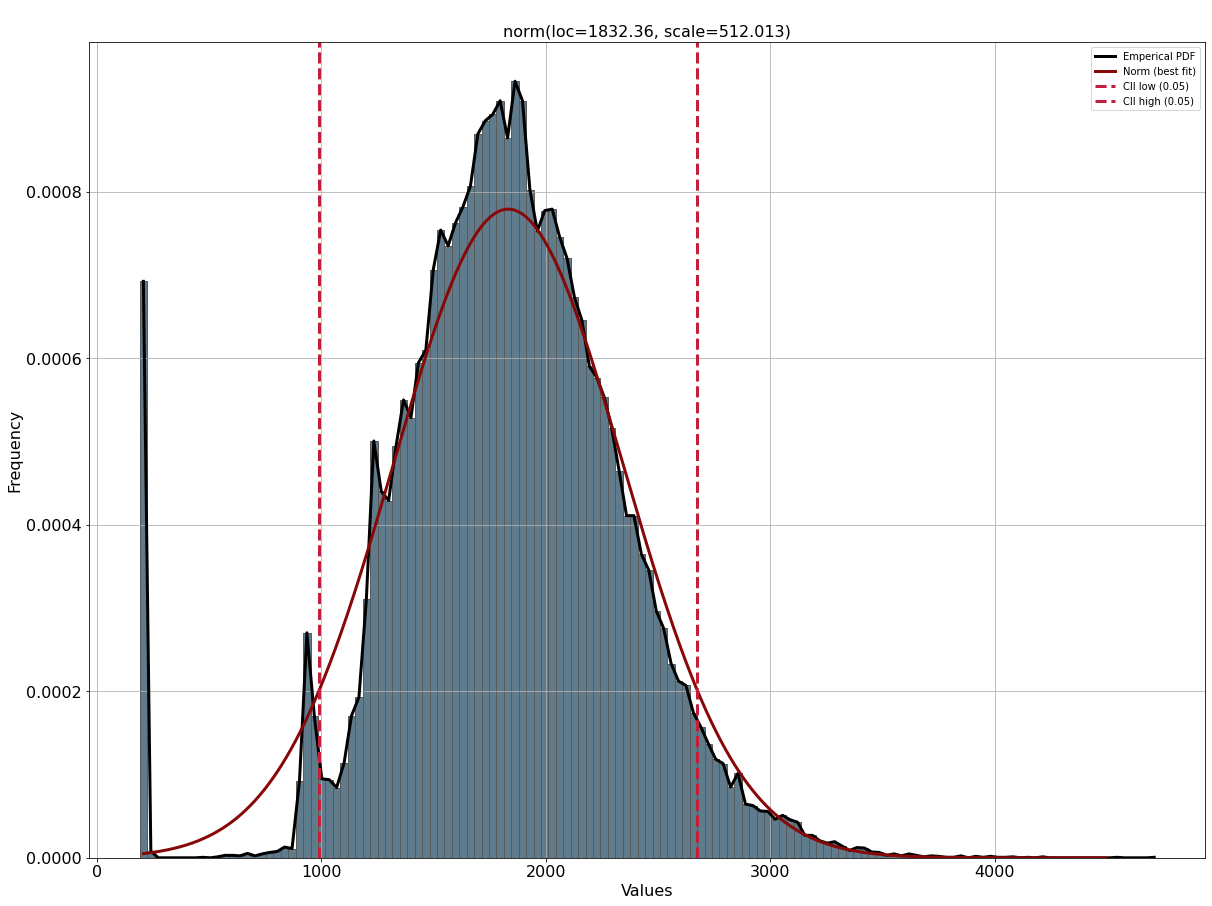

In [34]:
# Distribution
from distfit import distfit


dfit = distfit(todf=True)
results = dfit.fit_transform(df['gameDuration'])

dfit.plot()

Note that remaked matches are included in this dataframe, so i will remove them. I will remove the match periods from 3 to 15 minutes. Above that ff is possible and actual wins are unlikely. There may be some low-time ff due to disconnect but, in my interpretation, removing them is reasonable

In [35]:
remake = df[df['gameDuration'] <= 90].shape[0]
between_remake_and_surrender = df[((df['gameDuration'] > 900) & (df['gameDuration']<180))].shape[0]

print("remake: ", remake,"  between remake and surrender: ", between_remake_and_surrender)

remake:  0   between remake and surrender:  1309


In [36]:
df[((df['gameDuration'] < 900) & (df['gameDuration']>180))]

df_model = df.copy()

In [37]:
df.shape[0]-1309

50181

In [38]:
# Removing potential remake matches
df = df[~((df['gameDuration'] < 900) & (df['gameDuration']>180))]

[distfit] >ERROR> This release requires matplotlib version >= 3.5.2. Try: pip install -U matplotlib
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 2.50123e-07] [loc=1873.638 scale=448.629]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 9.88751e-06] [loc=901.000 scale=972.638]
[distfit] >INFO> [pareto    ] [2.11 sec] [RSS: 1.64451e-05] [loc=-0.184 scale=901.184]
[distfit] >INFO> [dweibull  ] [1.46 sec] [RSS: 7.53606e-07] [loc=1857.378 scale=380.519]
[distfit] >INFO> [t         ] [0.81 sec] [RSS: 2.50131e-07] [loc=1873.640 scale=448.629]
[distfit] >INFO> [genextreme] [2.55 sec] [RSS: 3.70552e-05] [loc=902.920 scale=8.774]
[distfit] >INFO> [gamma     ] [0.31 sec] [RSS: 1.42055e-07] [loc=-158.783 scale=99.201]
[distfit] >INFO> [lognorm   ] [2.64 sec] [RSS: 1.41342e-07] [loc=-1169.975 scale=3011.042]
[distfit] >INFO> [beta      ] [1.17 sec] [RSS: 1.42152e-07] [loc=-157.000 scale=557267672.014]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 1.1

(<Figure size 1440x1080 with 1 Axes>,
 <AxesSubplot:title={'center':'\nlognorm(s=0.14672, loc=-1169.98, scale=3011.04)'}, xlabel='Values', ylabel='Frequency'>)

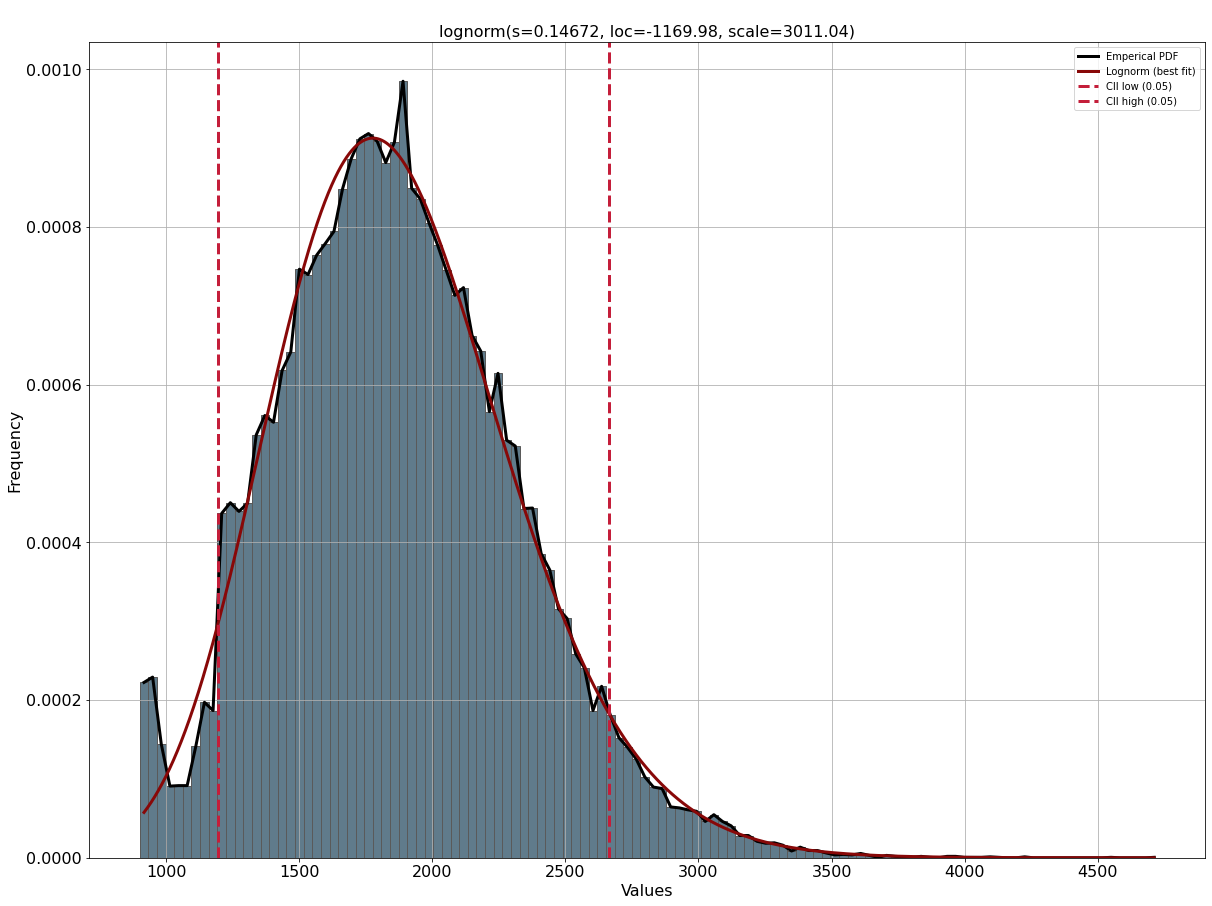

In [39]:
# Ploting distribution again
from distfit import distfit


dfit = distfit(todf=True)
results = dfit.fit_transform(df['gameDuration'])
dfit.plot()


### Analyzing champions' win percentage and pick/ban rate

In [40]:
# Analyzing champions' win percentage and pick/ban rate

champs_t1, champs_t2, bans_t1, bans_t2 = [],[],[],[]

# Getting columns that contains champions' appearances 'automatically'

# When testing, checking whether its alread in champ_t1 became necessary since compyling it twice
# would duplicate the list's values
for column in df.columns:
    if 'id' in column:
        if 't1' in column and column not in champs_t1:
            champs_t1.append(column)
        elif 't2' in column and column not in champs_t2:
            champs_t2.append(column)
    if 'ban' in column:
        if 't1' in column and column not in bans_t1:
            bans_t1.append(column)
        elif 't2' in column and column not in bans_t2:
            bans_t2.append(column)

In [41]:
# Extracting picked/banned percentage and getting the relevance:
# how many times a champion is picked when its not banned
# (number of picks) / ((total games) - (number of bans))
# In my opinion, this number would infer the best bans

df['picks'] = df[champs_t1 + champs_t2].values.tolist()
df['bans'] = df[bans_t1 + bans_t2].values.tolist()

df['comp'] = df[champs_t1 + champs_t2].values.tolist()

# I struggled a lot to assign lists/arrays to specific cells, so here's the solution i came up with
df['win/lose'] = np.where(df['winner'] == 1, '[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]', '[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]')
df['win/lose'] = df['win/lose'].apply(ast.literal_eval)
df_exploded = df.explode(['picks','bans','win/lose'])

pick_id = df_exploded['picks'].value_counts().reset_index()
ban_id = df_exploded['bans'].value_counts().reset_index()
winrate_id = df_exploded[['picks','win/lose']].groupby('picks').sum().reset_index()
winrate_id.rename(columns={'picks': 'index'},inplace=True)


# Since pd.merge only works for 2 dfs, had to do a step inside it
df_champion_stats = pd.merge(pick_id,pd.merge(ban_id,winrate_id,on='index'),on='index')
df_champion_stats['picked or banned (%)'] = (df_champion_stats['picks'] + df_champion_stats['bans'])*100/df.shape[0]
df_champion_stats['relevance (%)'] = df_champion_stats['picks']/(df.shape[0]-df_champion_stats['bans'])*100

df_exploded['picks'].value_counts().reset_index()

df_champion_stats.rename(columns={'index': 'id'}, inplace= True)
df_champion_stats = pd.merge(champs_df,df_champion_stats,on='id')

df_champion_stats[['picked or banned (%)', 'relevance (%)']] = df_champion_stats[['picked or banned (%)', 'relevance (%)']].round(2)
df_champion_stats.sort_values(by='relevance (%)', ascending = False)
df_champion_stats['winrate (%)'] = round(100*df_champion_stats['win/lose']/df_champion_stats['picks'],2)

df_champion_stats = df_champion_stats.sort_values('winrate (%)', ascending=False)

df_champion_stats

,id,name,role,picks,bans,win/lose,picked or banned (%),relevance (%),winrate (%)
39,40,Janna,"[Support, Mage]",8467,20921,4711,58.56,28.94,55.64
36,37,Sona,"[Support, Mage]",5298,595,2880,11.74,10.68,54.36
73,83,Yorick,"[Fighter, Tank]",1337,496,723,3.65,2.69,54.08
32,33,Rammus,"[Tank, Fighter]",2930,1798,1578,9.42,6.06,53.86
33,34,Anivia,"[Mage, Support]",2192,857,1177,6.08,4.44,53.70
...,...,...,...,...,...,...,...,...,...
68,78,Poppy,"[Tank, Fighter]",1840,155,832,3.98,3.68,45.22
42,43,Karma,"[Mage, Support]",3045,211,1372,6.49,6.09,45.06
128,268,Azir,"[Mage, Marksman]",1241,403,539,3.28,2.49,43.43
12,13,Ryze,"[Mage, Fighter]",1009,95,410,2.20,2.01,40.63


In [42]:
# Question: what team composition (i will be based only on roles, since champions would be more specific)
# has the highest winrate?
df['comp_1'] = df['picks'].apply(lambda x: x[:5])
df['comp_2'] = df['picks'].apply(lambda x: x[5:])


df[['winner','comp_1','comp_2']]
#cel.append(champs_df[champs_df['id'] == df.loc[0,'comp_1'][0]]['role'])

,winner,comp_1,comp_2
0,1,"[8, 432, 96, 11, 112]","[104, 498, 122, 238, 412]"
1,1,"[119, 39, 76, 10, 35]","[54, 25, 120, 157, 92]"
2,1,"[18, 141, 267, 68, 38]","[69, 412, 126, 24, 22]"
3,1,"[57, 63, 29, 61, 36]","[90, 19, 412, 92, 22]"
4,1,"[19, 29, 40, 119, 134]","[37, 59, 141, 38, 51]"
...,...,...,...
51485,2,"[19, 429, 91, 432, 64]","[45, 83, 67, 40, 79]"
51486,2,"[90, 32, 31, 412, 18]","[102, 429, 89, 75, 45]"
51487,2,"[141, 18, 432, 81, 68]","[1, 119, 33, 43, 99]"
51488,2,"[121, 236, 420, 201, 99]","[21, 56, 25, 30, 11]"


In [43]:
# Since trying to merge array with a dataframe is very tough, i will try it in another way:
# exploding it, merging and then making a list again

df_comps = df[['gameId','winner','comp_1','comp_2']]
df_comps = df_comps.explode(['comp_1','comp_2'])

df_comps = pd.merge(df_comps,champs_df.rename(columns={'id': 'comp_1','name':'name_1','role':'role_1'}), on='comp_1', sort=False)


df_comps = pd.merge(df_comps,champs_df.rename(columns={'id': 'comp_2','name':'name_2','role':'role_2'}), on='comp_2', sort=False)

df_comps = df_comps.sort_values('gameId')

# Here comes the tricky part: getting the team comps for each gameId
df_comps = df_comps.groupby('gameId').agg(
    {'comp_1': list, 
     'comp_2': list,
     'name_1': list,
     'name_2': list,
     'role_1': lambda x: [x.tolist()], 
     'role_2': lambda x: [x.tolist()], 
     'winner': 'first'
    }
).reset_index()

df_comps
# Note that the array is nested, so we have to undo it, for that i found a solution online

def unnest_array(array):
    # Unnest values and sort the role order
    # The reason i sorted is to prevent future errors of same composition with different orders
    unnested_array = sorted([item for sublist in array for sublist_2 in sublist for item in sublist_2], key=lambda x: x.lower())
    # Remove duplicates and return as sorted list
    return sorted(list(set(unnested_array)), key=lambda x: x.lower())

df_comps['role_1'] = df_comps['role_1'].apply(unnest_array)
df_comps['role_2'] = df_comps['role_2'].apply(unnest_array)


# Sorting names since pick order doesnt matter:

df_comps['name_1'] = df_comps['name_1'].apply(sorted)
df_comps['name_2'] = df_comps['name_2'].apply(sorted)


In [44]:
df_comps

,gameId,comp_1,comp_2,name_1,name_2,role_1,role_2,winner
0,3214824413,"[114, 40, 22, 11, 1]","[427, 412, 17, 245, 202]","[Annie, Ashe, Fiora, Janna, Master Yi]","[Ekko, Ivern, Jhin, Teemo, Thresh]","[Assassin, Fighter, Mage, Marksman, Support]","[Assassin, Fighter, Mage, Marksman, Support]",2
1,3214825708,"[266, 110, 121, 432, 131]","[103, 412, 58, 64, 29]","[Aatrox, Bard, Diana, Kha'Zix, Varus]","[Ahri, Lee Sin, Renekton, Thresh, Twitch]","[Assassin, Fighter, Mage, Marksman, Support, T...","[Assassin, Fighter, Mage, Marksman, Support, T...",1
2,3214843995,"[412, 41, 61, 64, 51]","[429, 54, 432, 104, 126]","[Caitlyn, Gangplank, Lee Sin, Orianna, Thresh]","[Bard, Graves, Jayce, Kalista, Malphite]","[Assassin, Fighter, Mage, Marksman, Support]","[Fighter, Mage, Marksman, Support, Tank]",1
3,3214844763,"[119, 35, 25, 14, 69]","[58, 236, 112, 412, 20]","[Cassiopeia, Draven, Morgana, Shaco, Sion]","[Lucian, Nunu, Renekton, Thresh, Viktor]","[Assassin, Fighter, Mage, Marksman, Support, T...","[Fighter, Mage, Marksman, Support, Tank]",1
4,3214845925,"[266, 40, 67, 105, 427]","[16, 34, 240, 161, 20]","[Aatrox, Fizz, Ivern, Janna, Vayne]","[Anivia, Kled, Nunu, Soraka, Vel'Koz]","[Assassin, Fighter, Mage, Marksman, Support, T...","[Fighter, Mage, Support, Tank]",2
...,...,...,...,...,...,...,...,...
49747,3331810857,"[43, 28, 103, 236, 31]","[19, 22, 238, 89, 57]","[Ahri, Cho'Gath, Evelynn, Karma, Lucian]","[Ashe, Leona, Maokai, Warwick, Zed]","[Assassin, Mage, Marksman, Support, Tank]","[Assassin, Fighter, Mage, Marksman, Support, T...",1
49748,3331821516,"[121, 29, 117, 57, 61]","[18, 201, 141, 63, 131]","[Kha'Zix, Lulu, Maokai, Orianna, Twitch]","[Brand, Braum, Diana, Kayn, Tristana]","[Assassin, Fighter, Mage, Marksman, Support, T...","[Assassin, Fighter, Mage, Marksman, Support, T...",2
49749,3331828122,"[150, 60, 41, 44, 429]","[79, 202, 99, 163, 23]","[Elise, Gangplank, Gnar, Kalista, Taric]","[Gragas, Jhin, Lux, Taliyah, Tryndamere]","[Fighter, Mage, Marksman, Support, Tank]","[Assassin, Fighter, Mage, Marksman, Support]",1
49750,3331830734,"[75, 498, 25, 157, 60]","[122, 102, 96, 67, 12]","[Elise, Morgana, Nasus, Xayah, Yasuo]","[Alistar, Darius, Kog'Maw, Shyvana, Vayne]","[Assassin, Fighter, Mage, Marksman, Support, T...","[Assassin, Fighter, Mage, Marksman, Support, T...",2


In [45]:
# Get most picked roles:
df_comps['role_1'] = df_comps['role_1'].astype(str)
df_comps['role_2'] = df_comps['role_2'].astype(str)


pd.concat([df_comps['role_1'],df_comps['role_2']]).value_counts()

df_comps[df_comps['role_1'] == df_comps['role_2']]

#df_comps

,gameId,comp_1,comp_2,name_1,name_2,role_1,role_2,winner
0,3214824413,"[114, 40, 22, 11, 1]","[427, 412, 17, 245, 202]","[Annie, Ashe, Fiora, Janna, Master Yi]","[Ekko, Ivern, Jhin, Teemo, Thresh]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",2
1,3214825708,"[266, 110, 121, 432, 131]","[103, 412, 58, 64, 29]","[Aatrox, Bard, Diana, Kha'Zix, Varus]","[Ahri, Lee Sin, Renekton, Thresh, Twitch]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",1
11,3215007763,"[154, 202, 497, 157, 25]","[143, 99, 3, 21, 11]","[Jhin, Morgana, Rakan, Yasuo, Zac]","[Galio, Lux, Master Yi, Miss Fortune, Zyra]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",2
12,3215041328,"[75, 55, 67, 20, 11]","[103, 98, 89, 236, 33]","[Katarina, Master Yi, Nasus, Nunu, Vayne]","[Ahri, Leona, Lucian, Rammus, Shen]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",2
15,3215045588,"[161, 67, 61, 31, 41]","[99, 35, 19, 412, 104]","[Cho'Gath, Gangplank, Orianna, Vayne, Vel'Koz]","[Graves, Lux, Shaco, Thresh, Warwick]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",2
...,...,...,...,...,...,...,...,...
49742,3331750863,"[113, 45, 133, 18, 16]","[61, 202, 412, 57, 141]","[Quinn, Sejuani, Soraka, Tristana, Veigar]","[Jhin, Kayn, Maokai, Orianna, Thresh]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",1
49743,3331752455,"[90, 18, 136, 497, 113]","[13, 64, 236, 40, 516]","[Aurelion Sol, Malzahar, Rakan, Sejuani, Trist...","[Janna, Lee Sin, Lucian, Ornn, Ryze]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",2
49748,3331821516,"[121, 29, 117, 57, 61]","[18, 201, 141, 63, 131]","[Kha'Zix, Lulu, Maokai, Orianna, Twitch]","[Brand, Braum, Diana, Kayn, Tristana]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",2
49750,3331830734,"[75, 498, 25, 157, 60]","[122, 102, 96, 67, 12]","[Elise, Morgana, Nasus, Xayah, Yasuo]","[Alistar, Darius, Kog'Maw, Shyvana, Vayne]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",2


In [46]:
# Get most picked heroes compositions:
df_comps['name_1'] = df_comps['name_1'].astype(str)
df_comps['name_2'] = df_comps['name_2'].astype(str)


pd.concat([df_comps['name_1'],df_comps['name_2']]).value_counts()


['Karma', 'Kayle', 'Master Yi', 'Orianna', 'Vayne']             4
['Ahri', 'Blitzcrank', 'Kayn', 'Malphite', 'Tristana']          3
['Orianna', 'Sejuani', 'Thresh', 'Tryndamere', 'Twitch']        3
['Blitzcrank', 'Jarvan IV', 'Lee Sin', 'Orianna', 'Twitch']     3
['Jhin', 'Lee Sin', 'Nasus', 'Thresh', 'Ziggs']                 3
                                                               ..
['Braum', 'Heimerdinger', 'Kalista', 'Shen', 'Twisted Fate']    1
['Evelynn', 'Soraka', 'Syndra', 'Twitch', 'Urgot']              1
['Bard', 'Ekko', 'Hecarim', 'Jax', 'Lucian']                    1
['Ekko', 'Jarvan IV', 'Kalista', 'Lulu', 'Riven']               1
['Diana', 'Jax', 'Lee Sin', 'Soraka', 'Varus']                  1
Length: 98889, dtype: int64

Note that i got an information that is pretty odd: the most picked comp only repeated four times. That probably happened since most of the popular heroes either get picked by the other team or banned. 

In my personal experience, the first comp is pretty odd (i confess that i dont remember what was the time's meta), so that explains why the other teams didnt ban them (vayne and kayle are very specific champions)


So i wont even bother to determine the best composition's winrate

In [47]:
# Calculating roles winrate
# Since the same roles can be picked by both teams, i will remove those cases

df_comps_winrate = df_comps[df_comps['role_1'] != df_comps['role_2']]
results = pd.DataFrame(columns={"comp", "winner"})

for index, row in df_comps_winrate.iterrows():
    if row['winner'] == 1:
        line = pd.DataFrame({"comp": [row['role_1'], row['role_2']],
                             "winner": [1, 0]})
        pd.concat([results,line], ignore_index = True)
        


In [48]:
# Another approach

results = pd.DataFrame(columns={"comp", "winner"})
df_comps_winrate = df_comps[df_comps['role_1'] != df_comps['role_2']]

results[['comp','winner']] = [df_comps_winrate[df_comps_winrate['winner'] == 1]['role_1'],1]

results

,winner,comp
2,1,"['Assassin', 'Fighter', 'Mage', 'Marksman', 'S..."
3,1,"['Assassin', 'Fighter', 'Mage', 'Marksman', 'S..."
6,1,"['Assassin', 'Fighter', 'Mage', 'Marksman', 'T..."
10,1,"['Assassin', 'Fighter', 'Mage', 'Marksman', 'S..."
13,1,"['Fighter', 'Mage', 'Marksman', 'Support', 'Ta..."
...,...,...
49740,1,"['Assassin', 'Fighter', 'Marksman', 'Support']"
49741,1,"['Assassin', 'Fighter', 'Mage', 'Marksman', 'S..."
49745,1,"['Assassin', 'Fighter', 'Mage', 'Marksman', 'S..."
49747,1,"['Assassin', 'Mage', 'Marksman', 'Support', 'T..."


In [49]:
# This one was a bit crafty. i want to get comp_1 and comp_2 and assure which one was winner
# or loser. For that, i used winner % 2 +1 , this way when winner =1 i get 2 and when winner = 2 i get
# 1


results_data = []
for _, row in df_comps_winrate.iterrows():
    comp_winner = row['role_' + str(row['winner'])]
    comp_loser = row['role_' + str(row['winner'] % 2 + 1)]
    
    results_data.append({'comp': comp_winner, 'winner': 1})
    results_data.append({'comp': comp_loser, 'winner': 0})

results = pd.DataFrame(results_data)


In [50]:
results.groupby('comp').value_counts()

comp                                                            winner
['Assassin', 'Fighter', 'Mage', 'Marksman', 'Support', 'Tank']  1         12934
                                                                0         12016
['Assassin', 'Fighter', 'Mage', 'Marksman', 'Support']          0          7636
                                                                1          7536
['Assassin', 'Fighter', 'Mage', 'Marksman', 'Tank']             0          3956
                                                                          ...  
['Mage', 'Marksman', 'Support', 'Tank']                         1           128
['Mage', 'Marksman', 'Support']                                 1            16
                                                                0            16
['Mage', 'Marksman', 'Tank']                                    0             4
['Mage', 'Support', 'Tank']                                     0             1
Length: 70, dtype: int64

In [51]:
comp_report = results.groupby('comp').agg({
    'winner': ['sum','count']
})

comp_report['winner','winrate'] = round(100*comp_report['winner']['sum']/comp_report['winner']['count'],2)

comp_report.sort_values(('winner','winrate'),ascending=False)

winner               
                                                      sum  count winrate
comp                                                                    
['Fighter', 'Marksman', 'Support']                      3      4   75.00
['Assassin', 'Marksman', 'Support', 'Tank']             2      3   66.67
['Assassin', 'Fighter', 'Support']                      2      3   66.67
['Fighter', 'Marksman', 'Tank']                        28     47   59.57
['Assassin', 'Fighter', 'Support', 'Tank']             20     35   57.14
['Fighter', 'Mage', 'Tank']                             7     13   53.85
['Assassin', 'Mage', 'Marksman']                        7     13   53.85
['Assassin', 'Fighter', 'Mage', 'Support']             66    124   53.23
['Assassin', 'Mage', 'Marksman', 'Tank']               28     53   52.83
['Assassin', 'Fighter', 'Mage', 'Marksman', 'Su...  12934  24950   51.84
['Assassin', 'Fighter', 'Tank']                        11     22   50.00
['Mage', 'Marksman', 'Support']                        16     32   50.00
['Fighter', 'Mage', 'Marksman', 'Tank']               485    971   49.95
['Assassin', 'Mage', 'Marksman', 'Support', 'Ta...    422    846   49.88
['Fighter', 'Mage', 'Marksman', 'Support']            315    632   49.84
['Assassin', 'Fighter', 'Mage', 'Marksman', 'Su...   7536  15172   49.67
['Assassin', 'Fighter', 'Mage', 'Marksman', 'Ta...   3902   7858   49.66
['Fighter', 'Mage', 'Marksman', 'Support', 'Tank']   4540   9306   48.79
['Assassin', 'Fighter', 'Mage', 'Support', 'Tank']    249    512   48.63
['Assassin', 'Fighter', 'Mage', 'Marksman']           542   1130   47.96
['Assassin', 'Fighter', 'Marksman', 'Support']        486   1015   47.88
['Assassin', 'Fighter', 'Marksman', 'Support', ...   2068   4320   47.87
['Fighter', 'Marksman', 'Support', 'Tank']             99    208   47.60
['Assassin', 'Mage', 'Marksman', 'Support']           155    330   46.97
['Assassin', 'Fighter', 'Marksman', 'Tank']           802   1739   46.12
['Assassin', 'Fighter', 'Mage', 'Tank']                78    170   45.88
['Mage', 'Marksman', 'Support', 'Tank']               128    281   45.55
['Assassin', 'Fighter', 'Mage']                         7     16   43.75
['Fighter', 'Mage', 'Support', 'Tank']                 39    110   35.45
['Assassin', 'Fighter', 'Marksman']                    23     65   35.38
['Fighter', 'Mage', 'Support']                          1      3   33.33
['Fighter', 'Mage', 'Marksman']                         4     14   28.57
['Mage', 'Marksman', 'Tank']                            0      4    0.00
['Assassin', 'Mage', 'Support']                         0      1    0.00
['Fighter', 'Tank']                                     0      1    0.00
['Fighter', 'Support', 'Tank']                          0      4    0.00
['Assassin', 'Marksman', 'Support']                     0      2    0.00
['Mage', 'Support', 'Tank']                             0      1    0.00

What sticks out the most for me was ['Fighter', 'Marksman', 'Tank'], its a pretty unusual composition

### Starting objectives analysis:
 - 1st Inhib
 - 1st Baron
 - 1st Tower
 - 1st Dragon
 - 1st Herald
 - 1st Blood

In [52]:
# Without taking 0 values out of the equation
df_1st = df.iloc[:,4:11]

df_1stwr = pd.DataFrame(columns=df_1st.columns[df_1st.columns != 'winner'] + ' (%)')

for column in df_1st.columns[df_1st.columns != 'winner']:
    df_1stwr.loc[0,column + ' (%)'] = round(100*df[df['winner'] == df[column]].shape[0]/df.shape[0], 2)

df_1stwr

,firstBlood (%),firstTower (%),firstInhibitor (%),firstBaron (%),firstDragon (%),firstRiftHerald (%)
0,59.0,70.73,81.86,50.21,66.99,35.01


Those low values can be explained by how often neither teams take barons/herald. So, theses numbers are false. Fixing it now:

In [53]:
# Taking 0 values out of the equation
df_1stwr = pd.DataFrame(columns=df_1st.columns[df_1st.columns != 'winner'] + ' (%)')

for column in df_1st.columns[df_1st.columns != 'winner']:
    df_1stwr.loc[0,column + ' (%)'] = round(100*df[((df['winner'] == df[column]) & \
                                                  (df[column] != 0))].shape[0] / \
                                       df[df[column] != 0].shape[0], 2)

df_1stwr

,firstBlood (%),firstTower (%),firstInhibitor (%),firstBaron (%),firstDragon (%),firstRiftHerald (%)
0,59.0,70.76,91.08,80.68,68.0,69.45


I have an idea of some kind of visualization to prove the importance of each objective, i will graphically show three scenarios:
1) Enemy team taking the 1st objective


2) None of the team taking it



3) The actual team taking it

In [54]:
import pandas as pd

df_1stwr = pd.DataFrame()

for column in df_1st.columns[df_1st.columns != 'winner']:
    for winner in [1, 2]:
        # 1st scenario: the team wins the game but the other team takes it
        df_1stwr.loc[0, str(winner) + column + ' (3rd)'] = int(round(100 * df[((df['winner'] == winner) & (df[column] != winner))].shape[0] / df[df[column] != winner].shape[0], 0))
        
        # 2nd scenario: None of the teams take it and the team wins the game
        df_1stwr.loc[0, str(winner) + column + ' (2nd)'] = int(round(100 * df[((df['winner'] == winner) & (df[column] == 0))].shape[0] / df[((df['winner'] == winner) & (df[column] == 0))].shape[0], 0)) if df[((df['winner'] == winner) & (df[column] == 0))].shape[0] else 0
        
        # 3rd scenario: the team wins the game and takes the objective (removing games that none of the teams took it)
        df_1stwr.loc[0, str(winner) + column + ' (1st)'] = int(round(100 * df[((df['winner'] == winner) & (df[column] == winner))].shape[0] / df[df[column] == winner].shape[0], 0))

df_1stwr.columns


Index(['1firstBlood (3rd)', '1firstBlood (2nd)', '1firstBlood (1st)',
       '2firstBlood (3rd)', '2firstBlood (2nd)', '2firstBlood (1st)',
       '1firstTower (3rd)', '1firstTower (2nd)', '1firstTower (1st)',
       '2firstTower (3rd)', '2firstTower (2nd)', '2firstTower (1st)',
       '1firstInhibitor (3rd)', '1firstInhibitor (2nd)',
       '1firstInhibitor (1st)', '2firstInhibitor (3rd)',
       '2firstInhibitor (2nd)', '2firstInhibitor (1st)', '1firstBaron (3rd)',
       '1firstBaron (2nd)', '1firstBaron (1st)', '2firstBaron (3rd)',
       '2firstBaron (2nd)', '2firstBaron (1st)', '1firstDragon (3rd)',
       '1firstDragon (2nd)', '1firstDragon (1st)', '2firstDragon (3rd)',
       '2firstDragon (2nd)', '2firstDragon (1st)', '1firstRiftHerald (3rd)',
       '1firstRiftHerald (2nd)', '1firstRiftHerald (1st)',
       '2firstRiftHerald (3rd)', '2firstRiftHerald (2nd)',
       '2firstRiftHerald (1st)'],
      dtype='object')

In [55]:
df_1stwr = pd.DataFrame()

for column in df_1st.columns[df_1st.columns != 'winner']:
    for winner in [1, 2]:
        # 1st scenario: the team wins the game but the other team takes it
        df_1stwr.loc[0, '[' + str(winner) + ']' + column + ' (3rd)'] = \
        int(round(100 * df[((df['winner'] == winner) & (df[column] != winner))].shape[0] 
                  / df[df[column] != winner].shape[0], 0))
        
        # 2nd scenario: None of the teams take it and the team wins the game
        
        # The if statement below is to avoid divided by 0 in first blood cases 
        # (since i removed the remake matches, there hasnt been one that ended without a kill)
        df_1stwr.loc[0, '[' + str(winner) + ']' + column + ' (2nd)'] = \
        int(round(100 * df[((df['winner'] == winner) & (df[column] == 0))].shape[0] 
                  / df[df[column] == 0].shape[0], 0)) if df[df[column] == 0].shape[0] else 0
        
        # 3rd scenario: the team wins the game and takes the objective (removing games that
        # none of the teams took it)
        df_1stwr.loc[0, '[' + str(winner) + ']' + column + ' (1st)'] = \
        int(round(100 * df[((df['winner'] == winner) & (df[column] == winner))].shape[0] 
                  / df[df[column] == winner].shape[0], 0))

df_1stwr


,[1]firstBlood (3rd),[1]firstBlood (2nd),[1]firstBlood (1st),[2]firstBlood (3rd),[2]firstBlood (2nd),[2]firstBlood (1st),[1]firstTower (3rd),[1]firstTower (2nd),[1]firstTower (1st),[2]firstTower (3rd),...,[1]firstDragon (1st),[2]firstDragon (3rd),[2]firstDragon (2nd),[2]firstDragon (1st),[1]firstRiftHerald (3rd),[1]firstRiftHerald (2nd),[1]firstRiftHerald (1st),[2]firstRiftHerald (3rd),[2]firstRiftHerald (2nd),[2]firstRiftHerald (1st)
0,41.0,0.0,59.0,41.0,0.0,59.0,29.0,72.0,71.0,29.0,...,69.0,32.0,44.0,67.0,44.0,51.0,69.0,43.0,49.0,69.0


Maybe this was a bit confusing, i will try to graphically show that:

In [56]:
df_1stwr

,[1]firstBlood (3rd),[1]firstBlood (2nd),[1]firstBlood (1st),[2]firstBlood (3rd),[2]firstBlood (2nd),[2]firstBlood (1st),[1]firstTower (3rd),[1]firstTower (2nd),[1]firstTower (1st),[2]firstTower (3rd),...,[1]firstDragon (1st),[2]firstDragon (3rd),[2]firstDragon (2nd),[2]firstDragon (1st),[1]firstRiftHerald (3rd),[1]firstRiftHerald (2nd),[1]firstRiftHerald (1st),[2]firstRiftHerald (3rd),[2]firstRiftHerald (2nd),[2]firstRiftHerald (1st)
0,41.0,0.0,59.0,41.0,0.0,59.0,29.0,72.0,71.0,29.0,...,69.0,32.0,44.0,67.0,44.0,51.0,69.0,43.0,49.0,69.0


In [57]:
import numpy as np
import matplotlib.pyplot as plt

def single_objective_analysis(objective):
    columns_chosen = [word for word in df_1stwr.columns if objective in word]
    
    df_graph = df_1stwr[columns_chosen]

    data = np.concatenate((df_graph.iloc[:3].values, df_graph.iloc[3:6].values), axis=0)

    labels = ["Other team's", "Neither team's", "Actual team's"]
    x = np.arange(len(labels))
    width = 0.3

    fig, ax = plt.subplots(figsize=(7, 4))


    bars1 = ax.bar(x - width/2, data[0, :3], width, label='Team 1', alpha=0.7)
    bars2 = ax.bar(x + width/2, data[0, -3:], width, label='Team 2', alpha=0.7)
    
    ax.set_ylabel('Percentage')
    ax.set_xlabel(objective)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Add percentage labels on each bar
    for bar1, bar2 in zip(bars1, bars2):
        ax.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height(), f'{int(bar1.get_height())}%', ha='center', va='bottom')
        ax.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height(), f'{int(bar2.get_height())}%', ha='center', va='bottom')

    plt.show()

This graph emphatizes the importance of objectives and also alert teams that they should take the objectives, since it'll increase the odds dramatically when compairing neither team getting and one team getting it

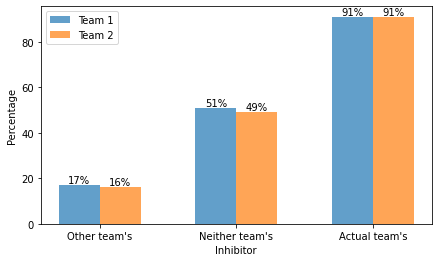

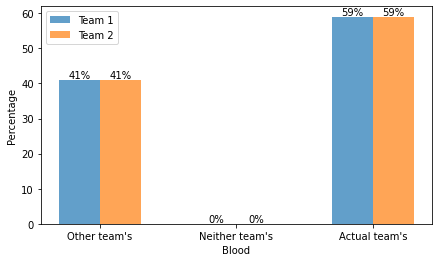

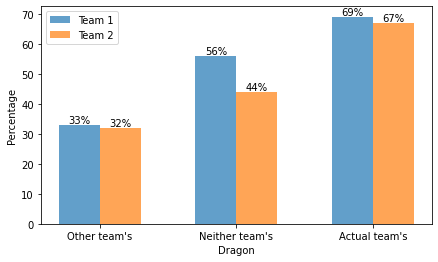

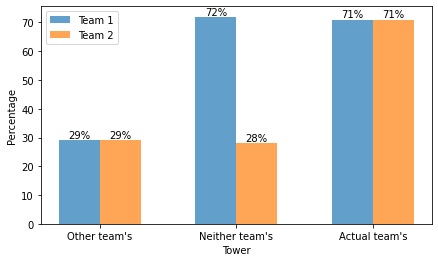

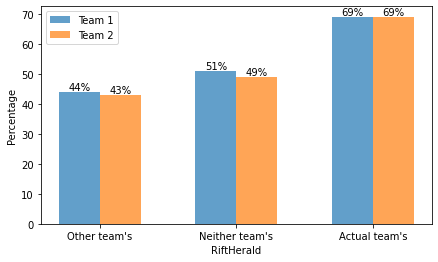

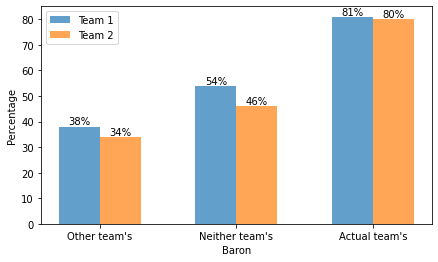

[None, None, None, None, None, None]

In [58]:
# Creating a single cell with every graph:

column_names = df_1stwr.columns
values = [name.split("first")[1].split(" (")[0] for name in column_names]
unique_values = list(set(values))
unique_values

[single_objective_analysis(obj) for obj in unique_values]

Putting it all in a single cell:

<Figure size 1224x576 with 0 Axes>

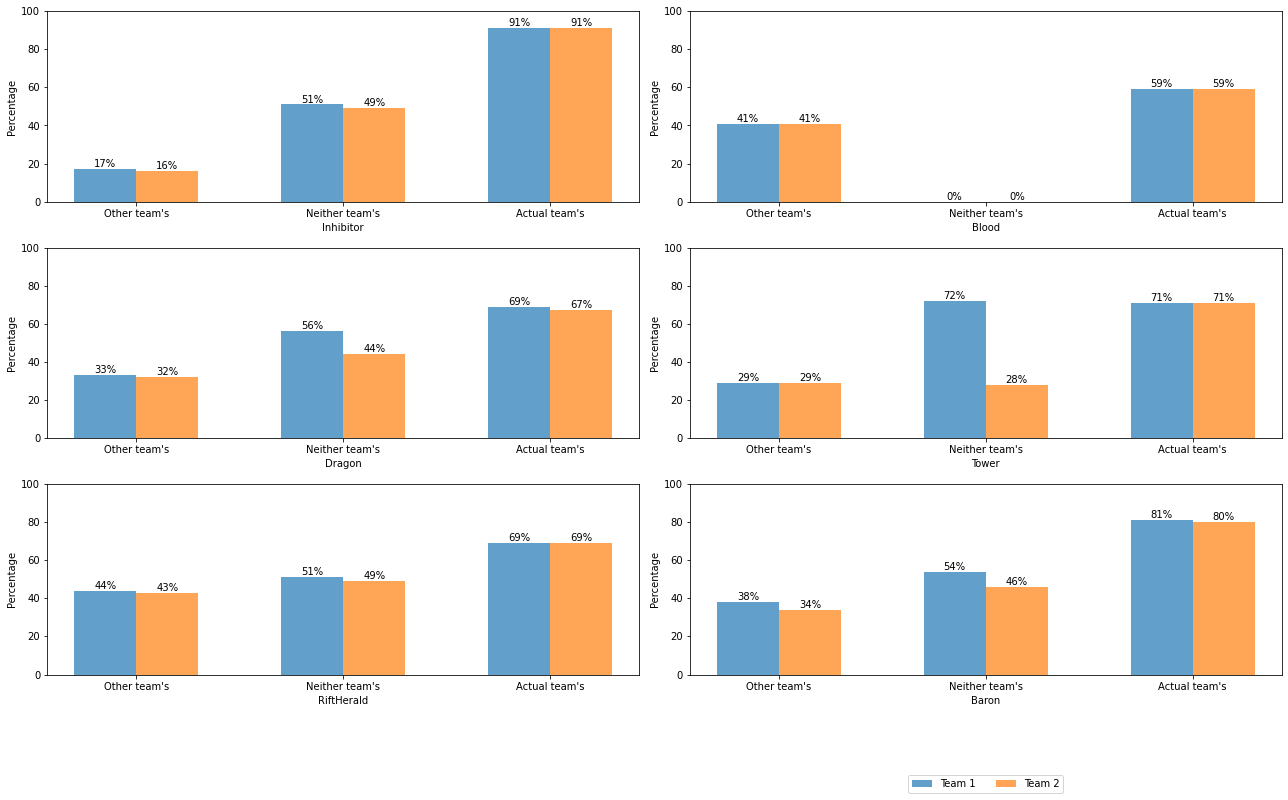

In [59]:
def objective_analysis(ax, objective):
    columns_chosen = [word for word in df_1stwr.columns if objective in word]
    
    df_graph = df_1stwr[columns_chosen]

    data = np.concatenate((df_graph.iloc[:3].values, df_graph.iloc[3:6].values), axis=0)

    labels = ["Other team's", "Neither team's", "Actual team's"]
    x = np.arange(len(labels))
    width = 0.3

    bars1 = ax.bar(x - width/2, data[0, :3], width, label='Team 1', alpha=0.7)
    bars2 = ax.bar(x + width/2, data[0, -3:], width, label='Team 2', alpha=0.7)
    
    ax.set_ylabel('Percentage')
    ax.set_xlabel(objective)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    # Add percentage labels on each bar
    for bar1, bar2 in zip(bars1, bars2):
        ax.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height(), f'{int(bar1.get_height())}%', ha='center', va='bottom')
        ax.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height(), f'{int(bar2.get_height())}%', ha='center', va='bottom')

    ax.set_ylim(top=100)
  

plt.figure(figsize=(17, 8))
# Create the subplot grid
num_plots = len(unique_values)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))

# Fill the subplots with the graphs
for i, objective in enumerate(unique_values):
    row = i // num_cols
    col = i % num_cols
    if num_rows == 1:
        ax = axes[col]
    else:
        ax = axes[row, col]
    objective_analysis(ax, objective)

# Adjust the layout of the subplots
plt.tight_layout()

# Move the legend outside the axes
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=2)

# Show the plot
plt.show()



OBS: Winning without taking towers/inhibs makes sense since it can be a forfeit

### Correlation between objectives, and objective vs winner (incomplete)

In [62]:
# First step is to transform them in binary

df_binary = pd.DataFrame(columns=['fb', 'ft'])


df_binary['fb'] = pd.concat

# winner_fb = pd.concat([df[df['winner'] == 1]['t1_towerKills'],df[df['winner'] == 2]['t2_towerKills']])

# loser_ft = pd.concat([df[df['winner'] == 1]['t2_towerKills'],df[df['winner'] == 2]['t1_towerKills']])



df_binary = df[['firstTower','firstBlood']].replace({1:1,2:0})


from sklearn.metrics import matthews_corrcoef

# Calcular a correlação de Matthews
correlation = matthews_corrcoef(df_binary['firstTower'], df_binary['firstBlood'])




print(correlation)

0.20963276215956478


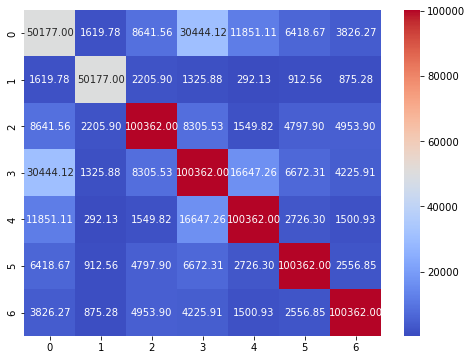

In [63]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Example data - replace with your own data
data = df[['winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald']]

# Calculating the chi-square statistic for each pair of variables
num_vars = data.shape[1]
chi2_matrix = np.zeros((num_vars, num_vars))

for i in range(num_vars):
    for j in range(num_vars):
        contingency_table = pd.crosstab(data.iloc[:, i], data.iloc[:, j])
        chi2, _, _, _ = chi2_contingency(contingency_table)
        chi2_matrix[i, j] = chi2

# Creating the heatmap using seaborn
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = sns.heatmap(chi2_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=ax)

# Set the colorbar limits
#heatmap.collections[0].colorbar.set_clim(0, 10000)


plt.show()


In [64]:
# Create a matrix of: winner, firstBlood, firstTower, firstInhib, firstBaron, firstDragon, firstHerald

In [65]:
data

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald
0,1,2,1,1,1,1,2
1,1,1,1,1,0,1,1
2,1,2,1,1,1,2,0
3,1,1,1,1,1,1,0
4,1,2,1,1,1,1,0
...,...,...,...,...,...,...,...
51485,2,1,2,2,0,2,0
51486,2,1,1,2,2,2,2
51487,2,2,2,2,0,1,0
51488,2,2,2,2,0,2,0


In [66]:
winner_towers = pd.concat([df[df['winner'] == 1]['t1_towerKills'],df[df['winner'] == 2]['t2_towerKills']])

loser_towers = pd.concat([df[df['winner'] == 1]['t2_towerKills'],df[df['winner'] == 2]['t1_towerKills']])


winner_towers = winner_towers.to_frame()

winner_towers['winner'] = 1
loser_towers = loser_towers.to_frame()
loser_towers['winner'] = 0
teste = pd.concat([winner_towers,loser_towers])


correlation = np.corrcoef(teste[0], teste['winner'])[0, 1]

print(correlation)

0.8088268136506851


### Starting to model: 
1) Predict the team winner with every piece of information we have on our disposal



2) It would be fun (especially for gamblers) to predict the winner with the minimal information available. I will do it using only team picks, bans, first blood, and first tower, as these pieces of information can be seen beforehand.

Removing irrelevant columns and separating features from target (winner)

In [67]:
df.drop(['gameId','creationTime','seasonId'],axis=1, inplace=True)

In [70]:
sum_columns = [columns for columns in df.columns if 'sum' in columns]
picks_bans = champs_t1 + champs_t2 + bans_t1 + bans_t2
features = df.drop(['winner','picks','bans','comp','win/lose'] + picks_bans + summoner_columns,axis=1)
target = df['winner']


I personally dont like the following approach, since different pick orders will be interpreted differently, but im curious to get the difference between a model with this problem and without it (for now i thought about sorting the picks)

In [71]:
df_model.columns
target = df_model['winner']
features = df_model.drop(['seasonId','winner','gameId','creationTime']+bans_t1+bans_t2+sum_columns, axis=1)


In [97]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


def model_and_results(features,target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    model = RandomForestClassifier()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    print("Matriz de Confusão:")
    #conf_matrix = confusion_matrix(y_test, y_pred)
    print(confusion_matrix(y_test, y_pred))


    accuracy = accuracy_score(y_test, y_pred)
    print("Acurácia:", accuracy)


    precision = precision_score(y_test, y_pred)
    print("Precisão:", precision)


    recall = recall_score(y_test, y_pred)
    print("Recall:", recall)


    f1 = f1_score(y_test, y_pred)
    print("F1-Score:", f1)
    
    importances = model.feature_importances_

    # Criar um DataFrame para visualizar as importâncias
    importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': importances})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Imprimir as importâncias das variáveis
    print('\n\n',importance_df)


Results are incredible! But let's dig a little more. I want to sort the picks:

In [74]:
df_model.copy()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,3308904636,1503076540231,1944,9,2,1,2,2,0,2,...,10,2,0,4,0,55,-1,90,238,157
51486,3215685759,1496957179355,3304,9,2,1,1,2,2,2,...,11,7,4,4,1,157,55,119,154,105
51487,3322765040,1504029863961,2156,9,2,2,2,2,0,1,...,10,2,0,2,0,113,122,53,11,157
51488,3256675373,1499562036246,1475,9,2,2,2,2,0,2,...,11,3,0,1,0,154,39,51,90,114


In [75]:
df_model[champs_t1].apply(lambda x: x[:5])

,t1_champ1id,t1_champ2id,t1_champ3id,t1_champ4id,t1_champ5id
0,8,432,96,11,112
1,119,39,76,10,35
2,18,141,267,68,38
3,57,63,29,61,36
4,19,29,40,119,134


In [79]:
df_model['comp_1'] = df_model[champs_t1].apply(sorted, axis=1)
df_model['comp_2'] = df_model[champs_t2].apply(sorted, axis=1)
split_1 = pd.DataFrame(df_model['comp_1'].to_list(), columns = champs_t1)
split_2 = pd.DataFrame(df_model['comp_2'].to_list(), columns = champs_t2)

split_sorted = pd.concat([split_1,split_2],axis=1)

sorted_features = pd.concat([df_model.drop(['gameId','creationTime','winner','seasonId']+champs_t1+champs_t2+bans_t1+bans_t2+summoner_columns,axis=1),split_sorted],axis=1)
sorted_features.drop(columns=['comp_1','comp_2'],inplace = True)

In [81]:
# Separe os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(sorted_features, target, test_size=0.2, random_state=42)

model = RandomForestClassifier()  # ou RandomForestClassifier

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [92]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_matrix)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


precision = precision_score(y_test, y_pred)
print("Precisão:", precision)


recall = recall_score(y_test, y_pred)
print("Precision:", recall)


f1 = f1_score(y_test, y_pred)
print("F1-Score:", f1)

Confusion Matrix:
[[5091  140]
 [ 167 4900]]
Accuracy: 0.9701883860943873
Precisão: 0.9682388740966147
Precision: 0.9732364748614032
F1-Score: 0.9707312422537897


In [87]:
sorted_win_prediction = sorted_features[champs_t1+champs_t2]

In [88]:
print('Apenas picks de cada time (em ordem)')

model_and_results(sorted_win_prediction,target)

Apenas picks de cada time (em ordem)
Matriz de Confusão:
[[2960 2271]
 [2678 2389]]
Acurácia: 0.5194212468440473
Precisão: 0.5250088683930472
Recall: 0.5658573886446187
F1-Score: 0.5446683227527831


        Feature  Importance
2  t1_champ3id    0.105132
7  t2_champ3id    0.104957
6  t2_champ2id    0.104004
8  t2_champ4id    0.103599
1  t1_champ2id    0.101580
3  t1_champ4id    0.101114
0  t1_champ1id    0.100153
5  t2_champ1id    0.099292
9  t2_champ5id    0.092544
4  t1_champ5id    0.087626


In [89]:
print('Picks with first main objectives')
model_and_results(df_model[champs_t1+champs_t2+['firstBlood','firstTower','firstDragon','firstRiftHerald']],target)

Picks with first main objectives
Matriz de Confusão:
[[3851 1380]
 [1518 3549]]
Acurácia: 0.7185861332297534
Precisão: 0.7172657850623952
Recall: 0.736188109348117
F1-Score: 0.7266037735849056


             Feature  Importance
11       firstTower    0.114922
12      firstDragon    0.082938
0       t1_champ1id    0.075024
1       t1_champ2id    0.074860
2       t1_champ3id    0.074728
5       t2_champ1id    0.074705
3       t1_champ4id    0.074687
8       t2_champ4id    0.074523
6       t2_champ2id    0.074374
9       t2_champ5id    0.074331
4       t1_champ5id    0.074253
7       t2_champ3id    0.074203
13  firstRiftHerald    0.037090
10       firstBlood    0.019362


In [90]:
print('Picks with first main objectives')



model_and_results(df_model[champs_t1+champs_t2+['firstBlood','firstTower']],target)

Picks with first main objectives
Matriz de Confusão:
[[3802 1429]
 [1541 3526]]
Acurácia: 0.7115944843658963
Precisão: 0.7115852517312371
Recall: 0.7268208755496081
F1-Score: 0.7191223756383582


         Feature  Importance
11   firstTower    0.152442
2   t1_champ3id    0.083305
7   t2_champ3id    0.083199
1   t1_champ2id    0.082600
0   t1_champ1id    0.082530
9   t2_champ5id    0.082529
5   t2_champ1id    0.082525
3   t1_champ4id    0.082346
6   t2_champ2id    0.082177
8   t2_champ4id    0.082169
4   t1_champ5id    0.081130
10   firstBlood    0.023048


Thats a pretty decent result. With only picks, first blood and first tower, we have 71% accuracy to predict the winner. Let me check if bans are relevant

In [91]:
print('Picks with first main objectives')
model_and_results(df_model[champs_t1+champs_t2+bans_t1+bans_t2+['firstBlood','firstTower']],target)

Picks with first main objectives
Matriz de Confusão:
[[3825 1406]
 [1546 3521]]
Acurácia: 0.7133423965818606
Precisão: 0.712157884937628
Recall: 0.7312177403938062
F1-Score: 0.7215619694397283


         Feature  Importance
21   firstTower    0.149107
7   t2_champ3id    0.043779
8   t2_champ4id    0.043664
2   t1_champ3id    0.043481
5   t2_champ1id    0.043212
0   t1_champ1id    0.043179
6   t2_champ2id    0.042948
3   t1_champ4id    0.042885
4   t1_champ5id    0.042830
1   t1_champ2id    0.042804
9   t2_champ5id    0.042722
13      t1_ban4    0.040359
19      t2_ban5    0.040121
17      t2_ban3    0.040038
12      t1_ban3    0.040019
18      t2_ban4    0.039959
14      t1_ban5    0.039877
10      t1_ban1    0.039869
16      t2_ban2    0.039834
11      t1_ban2    0.039538
15      t2_ban1    0.039315
20   firstBlood    0.020460
